<a href="https://colab.research.google.com/github/talhaanwarch/skin_cancer_detection_phone_camera/blob/master/ISIC2k19_six.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#data download

In [ ]:
!wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip

--2020-08-19 14:50:00--  https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.248.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.248.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771618190 (9.1G) [application/zip]
Saving to: ‘ISIC_2019_Training_Input.zip’

ISIC_2019_Training_ 100%[===================>]   9.10G  16.7MB/s    in 9m 51s  

2020-08-19 14:59:51 (15.8 MB/s) - ‘ISIC_2019_Training_Input.zip’ saved [9771618190/9771618190]



In [ ]:
%%capture
!unzip ISIC_2019_Training_Input.zip;

In [ ]:
rm ISIC_2019_Training_Input.zip

In [ ]:
!wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Test_Input.zip

--2020-08-19 15:04:45--  https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Test_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.104.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.104.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3823247963 (3.6G) [application/zip]
Saving to: ‘ISIC_2019_Test_Input.zip’

ISIC_2019_Test_Inpu 100%[===================>]   3.56G  16.6MB/s    in 3m 52s  

2020-08-19 15:08:38 (15.7 MB/s) - ‘ISIC_2019_Test_Input.zip’ saved [3823247963/3823247963]



In [ ]:
%%capture
!unzip ISIC_2019_Test_Input.zip;

In [ ]:
rm ISIC_2019_Test_Input.zip

In [ ]:
import pandas as pd
train_df=pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv')
train_df.drop('UNK',inplace=True,axis=1)
train_df['image']=train_df['image']+'.jpg'
train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(train_df)

25331

In [ ]:
train_df=train_df[train_df['DF']!=1]

In [ ]:
train_df=train_df[train_df['VASC']!=1]

In [ ]:
len(train_df)

24839

In [ ]:
train_df.drop(['DF','VASC'],axis=1,inplace=True)

In [ ]:
test_df=pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Test_Metadata.csv')
test_df['image']=test_df['image']+'.jpg'
test_df.head()

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321.jpg,60.0,NaN,female
1,ISIC_0034322.jpg,70.0,anterior torso,male
2,ISIC_0034323.jpg,70.0,lower extremity,male
3,ISIC_0034324.jpg,70.0,lower extremity,male
4,ISIC_0034325.jpg,30.0,upper extremity,female


In [ ]:
import cv2
img=cv2.imread('ISIC_2019_Test_Input/ISIC_0073120.jpg')
img.shape

(1024, 1024, 3)

#Model download

In [ ]:
%%capture
!pip install efficientnet

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df, test_size = 0.2)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

train_data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.2,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.2,
    brightness_range=[0.5, 1.5])

In [ ]:
img_shape=300
batch_size=20
col=train_df.columns[1::].to_list()
col

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'SCC']

In [ ]:
train_generator=train_data_gen.flow_from_dataframe(train,directory='/content/ISIC_2019_Training_Input',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="image",
                                                      y_col=col,
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=batch_size)

Found 19871 validated image filenames.


In [ ]:
val_generator=train_data_gen.flow_from_dataframe(val,directory='/content/ISIC_2019_Training_Input',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="image",
                                                      y_col=col,
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=batch_size)

Found 4968 validated image filenames.


In [ ]:
test_generator=train_data_gen.flow_from_dataframe(test_df,directory='/content/ISIC_2019_Test_Input',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="image",
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=batch_size)

Found 8238 validated image filenames.


In [ ]:
train_generator.next()[0].shape,train_generator.next()[1].shape

((20, 300, 300, 3), (20, 6))

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model




In [ ]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB3(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))

43933696/43933088 [==============================] - 4s 0us/step


In [ ]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(len(col), activation="softmax")(x)
model = Model(inputs=model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
def focal_loss(y_true, y_pred, alpha = 0.75, gamma = 2):
  alpha_factor = K.ones_like(y_true) * alpha
  alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
  focal_weight = tf.where(K.equal(y_true, 1), 1 - y_pred, y_pred)
  focal_weight = alpha_factor * focal_weight ** gamma
  loss = focal_weight * K.binary_crossentropy(y_true, y_pred)
  return loss

In [ ]:
model = Model(inputs=model.input, outputs=predictions)
#model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])
model.compile('adam',loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
results = model.fit(train_generator,epochs=10,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[
                                  ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)])

Epoch 1/10
994/993 [==============================] - 1561s 2s/step - loss: 1.0260 - accuracy: 0.6300 - val_loss: 0.8739 - val_accuracy: 0.6822
Epoch 2/10
994/993 [==============================] - 1513s 2s/step - loss: 0.8882 - accuracy: 0.6813 - val_loss: 0.8034 - val_accuracy: 0.7138
Epoch 3/10
994/993 [==============================] - 1526s 2s/step - loss: 0.8323 - accuracy: 0.6984 - val_loss: 0.8031 - val_accuracy: 0.7200
Epoch 4/10
994/993 [==============================] - 1505s 2s/step - loss: 0.7817 - accuracy: 0.7148 - val_loss: 0.7628 - val_accuracy: 0.7152
Epoch 5/10
994/993 [==============================] - 1491s 2s/step - loss: 0.7544 - accuracy: 0.7267 - val_loss: 0.7284 - val_accuracy: 0.7267
Epoch 6/10
994/993 [==============================] - 1478s 1s/step - loss: 0.7147 - accuracy: 0.7393 - val_loss: 0.7424 - val_accuracy: 0.7212
Epoch 7/10
994/993 [==============================] - 1490s 1s/step - loss: 0.6860 - accuracy: 0.7525 - val_loss: 0.7185 - val_accuracy:

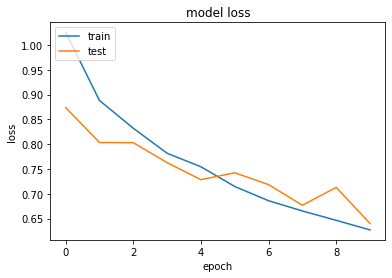

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(val_generator,steps=val_generator.n/batch_size)
y_pred=y_pred.round().astype(int)
y_true=val.iloc[:,1::].values



In [ ]:
from sklearn.metrics import accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.7562660351292678
0.6445385258677239


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
model.save_weights('/content/drive/My Drive/isic_weights/isic6_eff3_weights.hdf5')

In [ ]:
y_test = model.predict(test_generator,steps=test_generator.n/batch_size)
#y_test=y_test.round().astype(int)

In [ ]:
import numpy as np
d = pd.DataFrame(0, index=np.arange(len(y_test)), columns=col)
sub=pd.concat([test_df['image'],d],axis=1)
sub['image']=sub['image'].str.replace(r'.jpg', '')
sub.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0034321,0,0,0,0,0,0,0,0,0
1,ISIC_0034322,0,0,0,0,0,0,0,0,0
2,ISIC_0034323,0,0,0,0,0,0,0,0,0
3,ISIC_0034324,0,0,0,0,0,0,0,0,0
4,ISIC_0034325,0,0,0,0,0,0,0,0,0


In [ ]:
for i,j in enumerate(col):
    sub[j]=y_test[:,i]
sub.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0034321,0.044373,0.017932,9.586475e-01,0.000180,0.003910,5.599052e-03,1.416504e-04,0.000405,0.000000e+00
1,ISIC_0034322,0.000620,0.999036,0.000000e+00,0.000000,0.000079,8.136034e-06,8.940697e-08,0.000003,0.000000e+00
2,ISIC_0034323,0.002069,0.000971,5.707813e-01,0.024641,0.012428,4.199088e-02,1.130253e-03,0.044904,5.960464e-08
3,ISIC_0034324,0.063528,0.953907,2.980232e-08,0.000000,0.000104,6.854534e-07,3.278255e-07,0.000000,0.000000e+00
4,ISIC_0034325,0.000001,0.999997,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00


In [ ]:
sub.to_csv('effnet_binary.csv', index=False)

In [ ]:
from google.colab import files
files.download('effnet_binary.csv') 

In [ ]:
model.load_weights('model.h5')

In [ ]:
y_pred = model.predict_generator(val_generator,steps=val_generator.n/batch_size)
y_pred=y_pred.round().astype(int)

In [ ]:
y_true=val.iloc[:,1::].values
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))


0.8107361357805407
0.6658335333928403


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [ ]:
y_test = model.predict_generator(test_generator,steps=test_generator.n/batch_size)


In [ ]:
d = pd.DataFrame(0, index=np.arange(len(y_test)), columns=col)
sub=pd.concat([test_df['image'],d],axis=1)
sub['image']=sub['image'].str.replace(r'.jpg', '')
sub.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0034321,0,0,0,0,0,0,0,0,0
1,ISIC_0034322,0,0,0,0,0,0,0,0,0
2,ISIC_0034323,0,0,0,0,0,0,0,0,0
3,ISIC_0034324,0,0,0,0,0,0,0,0,0
4,ISIC_0034325,0,0,0,0,0,0,0,0,0


In [ ]:
for i,j in enumerate(col):
    sub[j]=y_test[:,i]
sub.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0034321,0.030809,0.077074,0.946737,0.000228,0.004595,0.001822,0.000128,2.401769e-04,0.0
1,ISIC_0034322,0.018896,0.977762,0.000003,0.000006,0.001700,0.000102,0.000001,1.843274e-04,0.0
2,ISIC_0034323,0.000698,0.000038,0.946685,0.000876,0.000730,0.001417,0.000003,2.417856e-02,0.0
3,ISIC_0034324,0.001160,0.998322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
4,ISIC_0034325,0.000201,0.999921,0.000000,0.000000,0.000006,0.000000,0.000000,5.960464e-08,0.0


In [ ]:
sub.to_csv('effnet_binary_1.csv', index=False)